# Time invariant filtering

Given an input signal $\boldsymbol{x}_{1:N}=\{x_{1}, x_{2}, \cdots, x_N\}$ and a finite impulse response filter $H(z)=h_0 + h_1 z^{-1} + h_{K-1} z^{-(k-1)}$, an output signal $\boldsymbol{y}_{1:N}$ can be computed as

$y_n = \sum_{k=0}^{K-1} h_{k}x_{n-k}$
$= h_{0}x_{n} + h_{1}x_{n-1} + \cdots + h_{K-1}x_{n-({K-1})}$

The above equation is similar to 1D convolution with one input and one output channel.
Furthermore, the time invariant filtering process is differentiable.

![Images_1](./figures/fig_c5_1.png)


This notebook explains the time invariant filtering wrapper based on 1D convolution.
This wrapper expects:
1. Input tensor has shape (batchsize, length, dim)
2. Input filter coefficients is in shape (filter_order)
3. Output tensor has shape (batchsize, length, dim)

Suppose input tensor is in shape (batchsize=B, length, dim=N). The wrapper interprets the input tensor as BxN 1-d signals of size (1, length, 1). It filters the BxN 1-d signals independently, using the same filter coefficients.


### 1. Module definition

Figure below illustrates the operations in the wrapper. Note that:
1. This wrapper depends on the conv1d wrapper
2. This wrapper processes all the 1-d signals using the same filter coefficients

![Images_1](./figures/fig_c5_2.png)


First, we repeat the definition of the conv1d wrapper:

In [1]:
import torch
import torch.nn as torch_nn
import torch.nn.functional as torch_nn_func

# repeat the definition of Conv1dKeepLength
class Conv1dKeepLength(torch_nn.Conv1d):
    """ Wrapper for causal convolution
    Input tensor:  (batchsize, length, dim_in)
    Output tensor: (batchsize, length, dim_out)
    
    Implemented based on:
    https://github.com/pytorch/pytorch/issues/1333
    
    Define:
        see __init__ below
    """
    def __init__(self, input_dim, output_dim, dilation_s, kernel_s, 
                 causal = False, stride = 1, groups=1, bias=True, \
                 tanh = True, pad_mode='constant'):
        super(Conv1dKeepLength, self).__init__(
            input_dim, output_dim, kernel_s, stride=1,
            padding = 0, dilation = dilation_s, groups=groups, bias=bias)

        self.pad_mode = pad_mode
        self.causal = causal
        
        # padding size
        # input & output length will be the same
        if self.causal:
            # left pad to make the convolution causal
            self.pad_le = dilation_s * (kernel_s - 1)
            self.pad_ri = 0
        else:
            # pad on both sizes
            self.pad_le = dilation_s * (kernel_s - 1) // 2
            self.pad_ri = dilation_s * (kernel_s - 1) - self.pad_le
    
        # activation functions
        if tanh:
            self.l_ac = torch_nn.Tanh()
        else:
            self.l_ac = torch_nn.Identity()
        
    def forward(self, data):
        # https://github.com/pytorch/pytorch/issues/1333
        # permute to (batchsize=1, dim, length)
        # add one dimension as (batchsize=1, dim, ADDED_DIM, length)
        # pad to ADDED_DIM
        # squeeze and return to (batchsize=1, dim, length+pad_length)
        x = torch_nn_func.pad(data.permute(0, 2, 1).unsqueeze(2), \
                              (self.pad_le, self.pad_ri,0,0), \
                              mode = self.pad_mode).squeeze(2)
        # tanh(conv1())
        # permmute back to (batchsize=1, length, dim)
        output = self.l_ac(super(Conv1dKeepLength, self).forward(x))
        return output.permute(0, 2, 1)

Then, we define the time invariant filter wrapper

In [2]:
# definition of TimeInvFIRFilter

class TimeInvFIRFilter(Conv1dKeepLength):                                    
    """ Wrapper to define a FIR filter
        input tensor  (batchsize, length, feature_dim)
        output tensor (batchsize, length, feature_dim)
        
        Define:
            TimeInvFIRFilter(feature_dim, filter_coef, 
                             causal=True, flag_trainable=False)
        feature_dim: dimension of the feature in each time step
        filter_coef: a 1-D torch.tensor of the filter coefficients
        causal: causal filtering y_i = sum_k=0^K a_k x_i-k
                non-causal: y_i = sum_k=0^K a_k x_i+K/2-k
        flag_trainable: whether update filter coefficients (default False)
    """                                                                   
    def __init__(self, feature_dim, filter_coef, causal=True, 
                 flag_trainable=False):
        # define based on Conv1d with stride=1, tanh=False, bias=False
        # groups = feature_dim make sure that each signal is filtered separated 
        super(TimeInvFIRFilter, self).__init__(                              
            feature_dim, feature_dim, 1, filter_coef.shape[0], causal,              
            groups=feature_dim, bias=False, tanh=False)
        
        if filter_coef.ndim == 1:
            # initialize weight and load filter coefficients
            with torch.no_grad():
                tmp_coef = torch.zeros([feature_dim, 1, filter_coef.shape[0]])
                tmp_coef[:, 0, :] = filter_coef
                tmp_coef = torch.flip(tmp_coef, dims=[2])
                self.weight = torch.nn.Parameter(tmp_coef, requires_grad = flag_trainable)
        else:
            print("TimeInvFIRFilter expects filter_coef to be 1-D tensor")
            print("Please implement the code in __init__ if necessary")
            sys.exit(1)
                                                                                  
    def forward(self, data):                                              
        return super(TimeInvFIRFilter, self).forward(data)

There are a few things to pay attention to.

First, *TimeInvFirFilter* is a 1D convolution layer with *groups=feature_dim*. This is equivalent to use `groups=in_channels: each input channel is convolved with its own set of filters`, according [Pytorch doc](https://pytorch.org/docs/master/generated/torch.nn.Conv1d.html).

Second, the layer weight is initialized by duplicating the filter coefficients for each feature dimension (or input/output channel):
```
tmp_coef = torch.zeros([feature_dim, 1, filter_coef.shape[0]])
tmp_coef[:, 0, :] = filter_coef
```

Third, the layer weight need to be flipped. As being plotted in the first figure of this notebook, the cnn kernel is forumated as [h2, h1, h0]:
```
tmp_coef = torch.flip(tmp_coef, dims=[2])
```



### 2. Simple examples

Consider a simple example, where the filter has coefficients = [1, -0.5, -0.5]

(<Figure size 108x36 with 1 Axes>,
 [<matplotlib.axes._axes.Axes at 0x1555210fa490>])

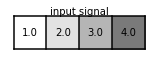

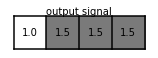

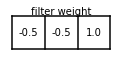

In [3]:
# input signal
data = torch.arange(1.0, 5.0, 1).unsqueeze(0).unsqueeze(2)

# filter coefficients
coef = [1, -0.5, -0.5]

# Initialzie the layer 
filter_layer = TimeInvFIRFilter(data.shape[-1], torch.tensor(coef))

# Do filtering using TimeInvFIRFilter
with torch.no_grad():
    # input signal
    signal_input = data
    # get output signal
    signal_output = filter_layer(signal_input)

import plot_lib
plot_lib.plot_tensor(data.permute(0, 2, 1), color_on_value=True, title="input signal")
plot_lib.plot_tensor(signal_output.permute(0, 2, 1), color_on_value=True, title="output signal")
plot_lib.plot_tensor(filter_layer.weight, color_on_value=False, colorgrad_x=False, colorgrad_y=False, title="filter weight")

Notice how the filter \[1, -0.5, -0.5\] is stored as \[-0.5, -0.5, 1.0\] in the 1D convolution layer.

Using the same filter coefficients = \[1, -0.5, -0.5\], let's consider another example where the input tensor is in shape (2, 5, 2). This correspond to the example in the 2nd figure of this notebook.

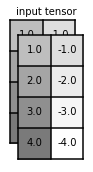

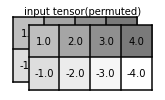

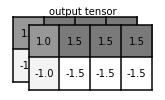

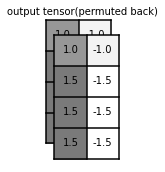

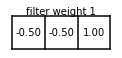

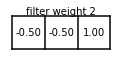

In [4]:
# input signal
data = torch.arange(1.0, 5.0, 1).unsqueeze(0).unsqueeze(2)
data = data.repeat(2, 1, 2)
data[:, :, 1] = torch.arange(-1.0, -5.0, -1)

# filter coefficients
coef = [1, -0.5, -0.5]

# initialize layer
filter_layer = TimeInvFIRFilter(data.shape[-1], torch.tensor(coef))

# Do filtering using TimeInvFIRFilter
with torch.no_grad():
    # input signal
    signal_input = data
    # get output signal
    signal_output = filter_layer(signal_input)

    
import plot_lib
plot_lib.plot_tensor(data, color_on_value=True, title="input tensor")
plot_lib.plot_tensor(data.permute(0, 2, 1), color_on_value=True, title="input tensor(permuted)")
plot_lib.plot_tensor(signal_output.permute(0, 2, 1), color_on_value=True, title="output tensor")
plot_lib.plot_tensor(signal_output, color_on_value=True, title="output tensor(permuted back)")

for feat_map_idx in range(filter_layer.weight.shape[0]):
    plot_lib.plot_tensor(filter_layer.weight[feat_map_idx:feat_map_idx+1], color_on_value=False, 
                         colorgrad_x=False, colorgrad_y=False, colormap='Greys', alpha=1.0,
                         title = 'filter weight %d' % (feat_map_idx + 1), deci_width=2)
    
#plot_lib.plot_tensor(torch.tensor(coef).unsqueeze(0).unsqueeze(1), color_on_value=False, 
#                         colorgrad_x=False, colorgrad_y=False, title="filter weight")

### 3. More complicated examples

In this example, we use high-pass and low-pass filters to process some random signals. 
We then plot the spectral amplitude of the input and filtered signals.

For sanity check, we also use the scipy.signal package to do the filtering, and we can compare the results.

In [5]:
from scipy import signal as sci_signal
import scipy.fft
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (10, 5)

# A few filters we can try
# these are the filters used in harmonic-plus-noise NSF
lp_v = [0.08538414199291068, 0.04920229475534168, -0.1470178606967731, 0.24737764593887432, 0.7103067853166558, 0.24737764593887432, -0.1470178606967731, 0.04920229475534168, 0.08538414199291068]
lp_u = [0.00936455546502, 0.0416254862901, 0.0878313219556, 0.146086321198, 0.192602581136, 0.211221591449, 0.192602581136, 0.146086321198, 0.0878313219556, 0.0416254862901, 0.00936455546502]
hp_v = [-0.00936455546502148, 0.04162548629009957, -0.08783132195564508, 0.1460863211980122, -0.19260258113649556,  0.21122159144894015, -0.19260258113649556, 0.1460863211980122, -0.08783132195564508, 0.04162548629009957, -0.00936455546502148]
hp_u = [0.0853841419929, -0.0492022947553, -0.147017860697, -0.247377645939, 0.710306785317, -0.247377645939, -0.147017860697, -0.0492022947553, 0.0853841419929]

# let's try a loss-pass filter
coef = lp_u

# configurations
signal_dim = 2
signal_length = 1000
batch_size = 2

# Do filtering using TimeInvFIRFilter
filter_layer = TimeInvFIRFilter(signal_dim, torch.tensor(coef))
with torch.no_grad():
    # input signal
    signal_input = torch.randn(batch_size, signal_length, signal_dim)
    signal_input = signal_input/signal_input.sum(axis=1, keepdim=True)
    # get output signal
    signal_output = filter_layer(signal_input)


After filtering, we can plot the input and output signals.

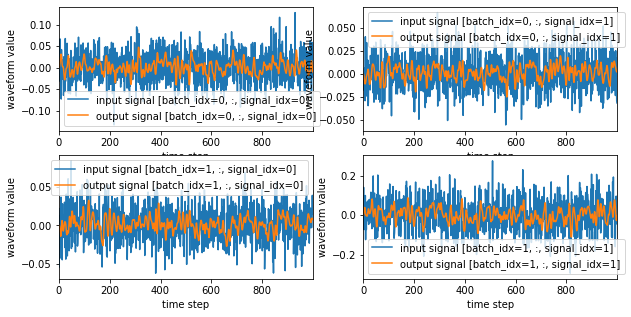

In [6]:
# plot the input and output signals 
batchsize = signal_input.shape[0]
signal_num = signal_input.shape[2] 

fig = plt.figure()
for batch_idx in range(batchsize):
    for signal_idx in range(signal_num):
        axis = fig.add_subplot(batchsize, signal_num, batch_idx * signal_num + signal_idx+1)

        plot_lib.plot_signal(signal_input[batch_idx, :, signal_idx].numpy(), fig, axis, xlabel='time step', ylabel='waveform value')
        plot_lib.plot_signal(signal_output[batch_idx, :, signal_idx].numpy(), fig, axis, xlabel='time step', ylabel='waveform value')
        plt.legend(['input signal [batch_idx=%d, :, signal_idx=%d]' % (batch_idx, signal_idx), 
                    'output signal [batch_idx=%d, :, signal_idx=%d]' % (batch_idx, signal_idx)])
        #axis.set_title('batch %d, signal %d' % (batch_idx, signal_idx))
        

Here we plot the spectra of the input and output signals.

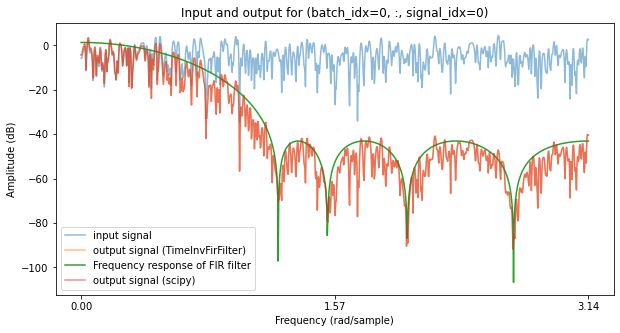

In [7]:
# plot results for 1 signal

# which signal to plot?
batch_idx = 0
signal_idx = 0

# fft points for figure plotting (nfft should be > signal_length)
nfft = 2048

# get the input and output signals from the tensor
signal_input_single = signal_input.numpy()[batch_idx, :, signal_idx]
signal_output_single = signal_output.numpy()[batch_idx, :, signal_idx] 

# Do filtering using scipy, for sanity check
scipy_output_scipy = scipy.signal.lfilter(coef, [1], signal_input_single)


# plot the spectral
def plot_spectral(signal_tmp, fig, axis):
    h = scipy.fft.fft(signal_tmp * np.hanning(signal_tmp.shape[0]), n=nfft)
    axis.plot(20*np.log10(np.abs(h[0:nfft//2+1]) + np.finfo(np.float32).eps), alpha=0.5)
    axis.set_title('Input and output for (batch_idx=%d, :, signal_idx=%d)' % (batch_idx, signal_idx))
    axis.set_xlabel('Frequency (rad/sample)')
    axis.set_ylabel('Amplitude (dB)')
    axis.set_xticks([0, nfft // 4, nfft // 2])
    axis.set_xticklabels(['%1.2f' % (x * 2 * np.pi) for x in [0, 0.25, 0.5]])
    
def plot_freq_response(filter_coef, fig, axis):
    w, h = scipy.signal.freqz(filter_coef, [1], worN=nfft, whole=True)
    axis.plot(20*np.log10(np.abs(h[0:nfft//2+1]) + np.finfo(np.float32).eps))

    
fig = plt.figure()
axis = fig.add_subplot(111)
plot_spectral(signal_input_single, fig, axis)
plot_spectral(signal_output_single, fig, axis)
plot_freq_response(coef, fig, axis)
plot_spectral(scipy_output_scipy, fig, axis)
plt.legend(['input signal', 'output signal (TimeInvFirFilter)', 
            'Frequency response of FIR filter', 'output signal (scipy)'])


Figure above shows how the low-pass FIR filter changes the spectrum of the input signal (input_tensor\[0, :, 0\]).
Also, the output from *scipy API* is identical to the output from the TimeVariantFilter wrapper.

You may try different FIR filters or different signals in the input tensor.

### 4. Moving-average-based smoothing

It is also straightforward to define moving-average-based signal smoothing function based on Conv1dKeepLength

While it is possible to define it using TimeInvFilter, I directly define in through Conv1dKeepLength

In [8]:
class MovingAverage(Conv1dKeepLength):                                    
    """ Wrapper to define a moving average smoothing layer based on Conv1dKeepLength
    input tensor  (batchsize, length, feature_dim)
    output tensor (batchsize, length, feature_dim)
    Moving averaging is conducted separately for each feature_dimension and each sequence 
    
    Define: 
        MovingAverage(feature_dim, window_len, causal=False)
        
        feature_dim: 
        window_len: the length of the moving average window
        causal: when False, the window is centered on the current point
                when True, it is y_i = 1/K * sum_k=0^K x_i-k 
    """                                                                   
    def __init__(self, feature_dim, window_len, causal=False):            
        super(MovingAverage, self).__init__(                              
            feature_dim, feature_dim, 1, window_len, causal,              
            groups=feature_dim, bias=False, tanh=False)
        # same
        torch_nn.init.constant_(self.weight, 1/window_len)                
        for p in self.parameters():                                       
            p.requires_grad = False                                       
                                                                          
    def forward(self, data):                                              
        return super(MovingAverage, self).forward(data)

One example to sue this moving average filter

(<Figure size 108x36 with 1 Axes>,
 [<matplotlib.axes._axes.Axes at 0x15551e8a73d0>])

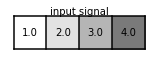

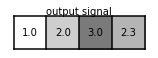

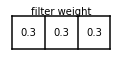

In [9]:
# input signal
data = torch.arange(1.0, 5.0, 1).unsqueeze(0).unsqueeze(2)

# length of the moving average filter (window)
window_size = 3

# Do filtering ()
filter_layer = MovingAverage(data.shape[2], window_size, causal = False)

with torch.no_grad():
    # input signal
    signal_input = data
    # get output signal
    signal_output = filter_layer(signal_input)

import plot_lib
plot_lib.plot_tensor(data.permute(0, 2, 1), color_on_value=True, title="input signal")
plot_lib.plot_tensor(signal_output.permute(0, 2, 1), color_on_value=True, title="output signal")
plot_lib.plot_tensor(filter_layer.weight, color_on_value=False, colorgrad_x=False, colorgrad_y=False, title="filter weight")

Here is another example on random signals. The signals are fed to the layer as a tensor of shape (2, 1000, 2).

In [10]:
   
# configurations
signal_dim = 2
signal_length = 1000
batch_size = 2
window_size_1 = 10

# Do filtering using TimeInvFIRFilter
ave_layer = MovingAverage(signal_dim, window_size_1, causal = False)

with torch.no_grad():
    # input signal (random noise)
    signal_input = torch.randn(batch_size, signal_length, signal_dim)
    
    # get output signal
    signal_output = ave_layer(signal_input)



Text(0.5, 1.0, 'Input and output signals after moving averge')

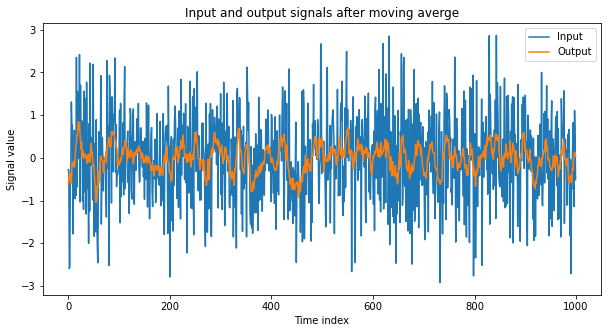

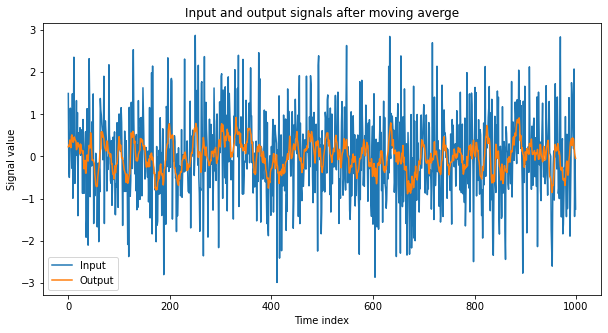

In [11]:

plt.figure()
plt.plot(signal_input[0, :, 0])
plt.plot(signal_output[0, :, 0])
plt.xlabel('Time index')
plt.ylabel('Signal value')
plt.legend(['Input', 'Output'])
plt.title('Input and output signals after moving averge')


plt.figure()
plt.plot(signal_input[0, :, 1])
plt.plot(signal_output[0, :, 1])
plt.xlabel('Time index')
plt.ylabel('Signal value')
plt.legend(['Input', 'Output'])
plt.title('Input and output signals after moving averge')

### 5. Summary

In this notebook, we explained the time invariant filter. This layer expects:
1. Input tensor has shape (batchsize, length, dim)
2. Input filter coefficients is in shape (filter_order)
3. Output tensor has shape (batchsize, length, dim)

This layer conducts filtering independently on each batch and dimension, using the same input filter coefficients.

The default TimeVariantFilter wrapper assume the filter coefficients are fixed and non-trainable.
However, the same wrapper also support trainable filter coefficients by setting *flag_trainable=True*. Such a trainable time-invariant filter may also be used for applications where the filter coefficients can be use to initialize the network and further fine-tuned on the data through back-propagation (for example, in https://www.isca-speech.org/archive/interspeech_2014/i14_0905.html)